# **Imports and Setup**

In [ ]:
import os
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout,Flatten, GlobalAveragePooling2D, MaxPooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

# Download & Extract Dataset from Kaggle

In [ ]:
import os

API = {"username":"","key":""}
os.environ['KAGGLE_USERNAME'] = API["username"]
os.environ['KAGGLE_KEY'] = API["key"]

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset_name = "vipoooool/new-plant-diseases-dataset"
api.dataset_download_files(dataset_name, path="leaf-disease-dataset", unzip=True)

# ! du -sh /kaggle/input
# ! du -sh /kaggle/working

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset


# Explore Folder Structure

In [ ]:
# ! rm -rf /kaggle/working/wandb/*
# ! rm -rf /kaggle/worzking/10_entropies
# ! ls
# ! tree
import os

def print_directory_structure(folder_path, prefix="", is_last=True):
    try:
        # List all items in the current directory
        items = os.listdir(folder_path)
        items.sort()  # Sort the items in ascending order
    except PermissionError:
        # Skip directories that cannot be accessed
        print(f"{prefix}├── [Permission Denied]")
        return

    # Separate directories and files
    files = []
    directories = []
    for item in items:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            files.append(item)
        elif os.path.isdir(item_path):
            directories.append(item)

    # Print the current directory and the number of files
    print(f"{prefix}{'└──' if is_last else '├──'} {os.path.basename(folder_path)}/ [{len(files)} files]")

    # Recursively print the structure of subdirectories
    total_items = len(directories)
    for i, directory in enumerate(directories):
        new_is_last = (i == total_items - 1)  # Check if it's the last directory
        new_prefix = prefix + ("    " if is_last else "│   ")  # Continue vertical bars correctly
        new_folder_path = os.path.join(folder_path, directory)
        print_directory_structure(new_folder_path, new_prefix, new_is_last)


folder_path = "./leaf-disease-dataset"
print_directory_structure(folder_path)

└── leaf-disease-dataset/ [0 files]
    ├── New Plant Diseases Dataset(Augmented)/ [0 files]
    │   └── New Plant Diseases Dataset(Augmented)/ [0 files]
    │       ├── train/ [0 files]
    │       │   ├── Apple___Apple_scab/ [2016 files]
    │       │   ├── Apple___Black_rot/ [1987 files]
    │       │   ├── Apple___Cedar_apple_rust/ [1760 files]
    │       │   ├── Apple___healthy/ [2008 files]
    │       │   ├── Blueberry___healthy/ [1816 files]
    │       │   ├── Cherry_(including_sour)___Powdery_mildew/ [1683 files]
    │       │   ├── Cherry_(including_sour)___healthy/ [1826 files]
    │       │   ├── Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/ [1642 files]
    │       │   ├── Corn_(maize)___Common_rust_/ [1907 files]
    │       │   ├── Corn_(maize)___Northern_Leaf_Blight/ [1908 files]
    │       │   ├── Corn_(maize)___healthy/ [1859 files]
    │       │   ├── Grape___Black_rot/ [1888 files]
    │       │   ├── Grape___Esca_(Black_Measles)/ [1920 files]
    │       │

In [ ]:
! ls ./leaf-disease-dataset/test/*

AppleCedarRust1.JPG	PotatoEarlyBlight2.JPG	TomatoEarlyBlight6.JPG
AppleCedarRust2.JPG	PotatoEarlyBlight3.JPG	TomatoHealthy1.JPG
AppleCedarRust3.JPG	PotatoEarlyBlight4.JPG	TomatoHealthy2.JPG
AppleCedarRust4.JPG	PotatoEarlyBlight5.JPG	TomatoHealthy3.JPG
AppleScab1.JPG		PotatoHealthy1.JPG	TomatoHealthy4.JPG
AppleScab2.JPG		PotatoHealthy2.JPG	TomatoYellowCurlVirus1.JPG
AppleScab3.JPG		TomatoEarlyBlight1.JPG	TomatoYellowCurlVirus2.JPG
CornCommonRust1.JPG	TomatoEarlyBlight2.JPG	TomatoYellowCurlVirus3.JPG
CornCommonRust2.JPG	TomatoEarlyBlight3.JPG	TomatoYellowCurlVirus4.JPG
CornCommonRust3.JPG	TomatoEarlyBlight4.JPG	TomatoYellowCurlVirus5.JPG
PotatoEarlyBlight1.JPG	TomatoEarlyBlight5.JPG	TomatoYellowCurlVirus6.JPG


``` As we can see that the downloaded dataset has three sub directories, two are duplicate (for train and val). We also have an additional test directory which contains one sample for each type of image ```

## Visualize and anaylyze the dataset

In [ ]:
# Configuration and define test folder
image_shape = (224, 224)
batch_size = 64
epochs = 10

data_path = './leaf-disease-dataset'
train_folder = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')
valid_folder = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'valid')
test_folder = os.path.join(data_path, 'test', 'test')

# **Create Data Generators**

In [ ]:
def create_data_generators():
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2 # for testing
)
    val_datagen = ImageDataGenerator(rescale=1/255.)
    test_datagen = ImageDataGenerator(rescale=1/255.)

    print("Training Images:")
    train_data = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset='training'  # 80% training
    )

    print("Validating Images:")
    valid_data = val_datagen.flow_from_directory(
        valid_folder,
        target_size=image_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    print("Test Images:")
    test_data = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset='validation'  # 20% test
    )

    return train_data, valid_data, test_data


# Usage
train_data, valid_data, test_data = create_data_generators()

Training Images:
Found 56251 images belonging to 38 classes.
Validating Images:
Found 17572 images belonging to 38 classes.
Test Images:
Found 14044 images belonging to 38 classes.


# Dataset Statistics


In [ ]:
# size of input image
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')

print()

# list of diseases
diseases = os.listdir(train_folder)
plants = [dis.split('___')[0] for dis in diseases]
plants = set(plants)

print(f"Number of unique plants in dataset: {len(plants)}")
for plant in plants:
  print(plant)

print()

print("Diseases in dataset:")
for disease in diseases:
  print(disease)

shape of image is : (224, 224, 3)

Number of unique plants in dataset: 14
Potato
Tomato
Corn_(maize)
Apple
Squash
Pepper,_bell
Peach
Blueberry
Raspberry
Orange
Cherry_(including_sour)
Soybean
Grape
Strawberry

Diseases in dataset:
Tomato___Tomato_mosaic_virus
Apple___Cedar_apple_rust
Tomato___Target_Spot
Potato___healthy
Strawberry___Leaf_scorch
Cherry_(including_sour)___healthy
Cherry_(including_sour)___Powdery_mildew
Strawberry___healthy
Potato___Early_blight
Squash___Powdery_mildew
Raspberry___healthy
Apple___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___healthy
Tomato___Early_blight
Pepper,_bell___Bacterial_spot
Peach___Bacterial_spot
Corn_(maize)___Common_rust_
Potato___Late_blight
Corn_(maize)___healthy
Soybean___healthy
Grape___Black_rot
Apple___Black_rot
Tomato___Spider_mites Two-spotted_spider_mite
Grape___healthy
Peach___healthy
Tomato___Bacterial_spot
Apple___Apple_scab
Grape___Esca_(Black_Measles)
Tomato___Leaf_Mold
Pepper,_bell___healthy
Orange___Haunglongbing_(C

num of images per plant

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_folder + '/' + disease))

# Convert Num Dict to Pandas DF
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])
img_per_class


No. of images
Tomato___Tomato_mosaic_virus                                 1790
Apple___Cedar_apple_rust                                     1760
Tomato___Target_Spot                                         1827
Potato___healthy                                             1824
Strawberry___Leaf_scorch                                     1774
Cherry_(including_sour)___healthy                            1826
Cherry_(including_sour)___Powdery_mildew                     1683
Strawberry___healthy                                         1824
Potato___Early_blight                                        1939
Squash___Powdery_mildew                                      1736
Raspberry___healthy                                          1781
Apple___healthy                                              2008
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___healthy                                             1926
Tomato___Early_blight                                        1920
Pepper,_bell___Bacterial_spot                                1913
Peach___Bacterial_spot                                       1838
Corn_(maize)___Common_rust_                                  1907
Potato___Late_blight                                         1939
Corn_(maize)___healthy                                       1859
Soybean___healthy                                            2022
Grape___Black_rot                                            1888
Apple___Black_rot                                            1987
Tomato___Spider_mites Two-spotted_spider_mite                1741
Grape___healthy                                              1692
Peach___healthy                                              1728
Tomato___Bacterial_spot                                      1702
Apple___Apple_scab                                           2016
Grape___Esca_(Black_Measles)                                 1920
Tomato___Leaf_Mold                                           1882
Pepper,_bell___healthy                                       1988
Orange___Haunglongbing_(Citrus_greening)                     2010
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Late_blight                                         1851
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Tomato___Septoria_leaf_spot                                  1745
Blueberry___healthy                                          1816

# **Class Distribution – Number of Images per Disease**

Text(0.5, 1.0, 'Images per each class of plant disease')

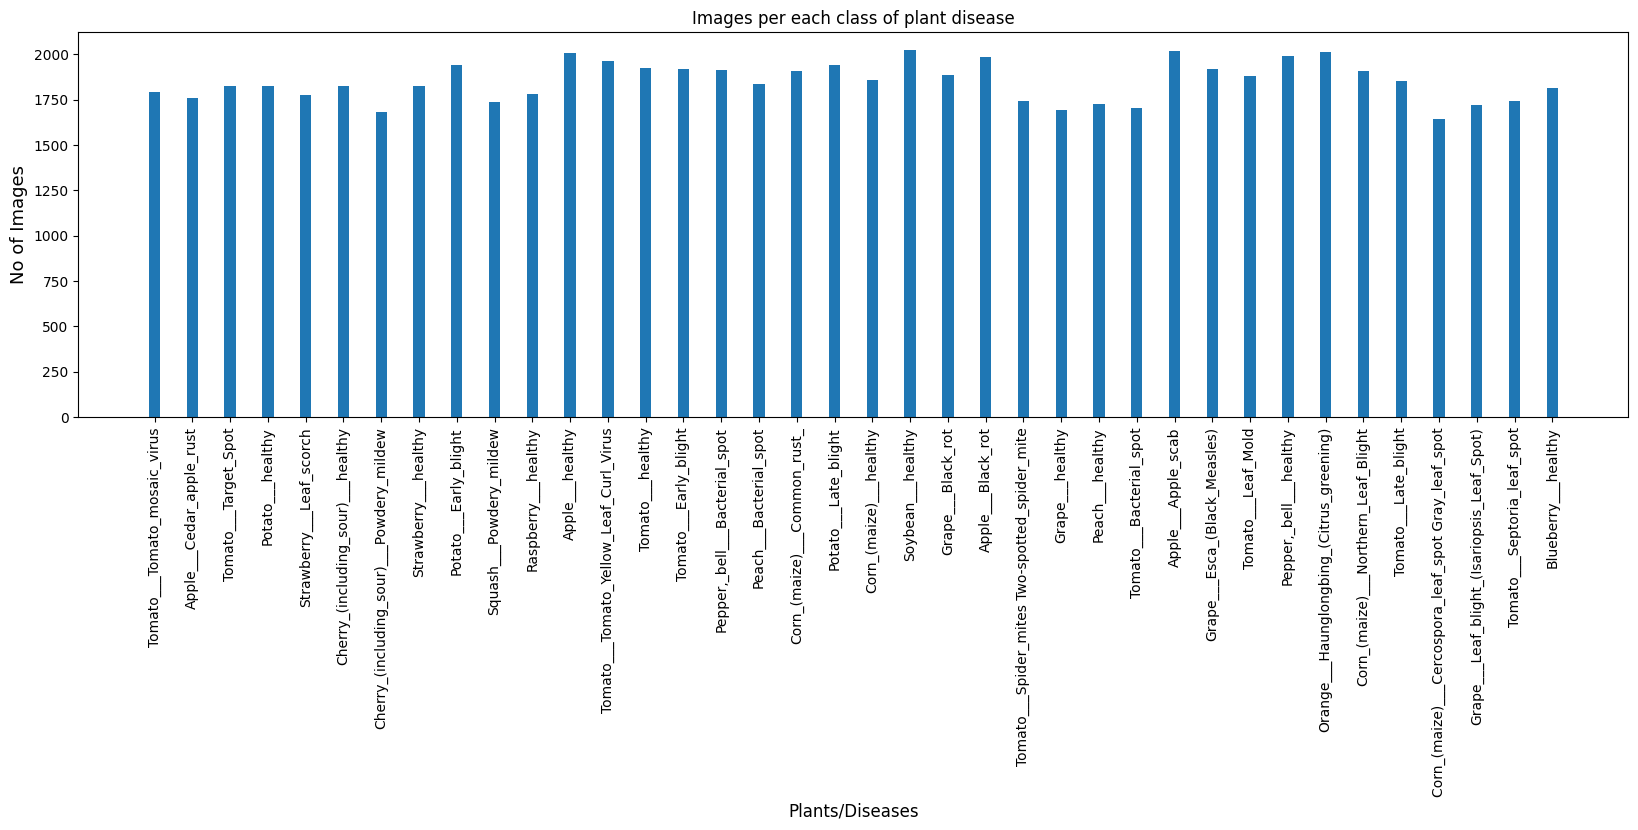

In [ ]:
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=12)
plt.ylabel('No of Images', fontsize=13)
plt.xticks(index, diseases, fontsize=10, rotation=90)

plt.title('Images per each class of plant disease')

# Random Sample of 16 Training Images

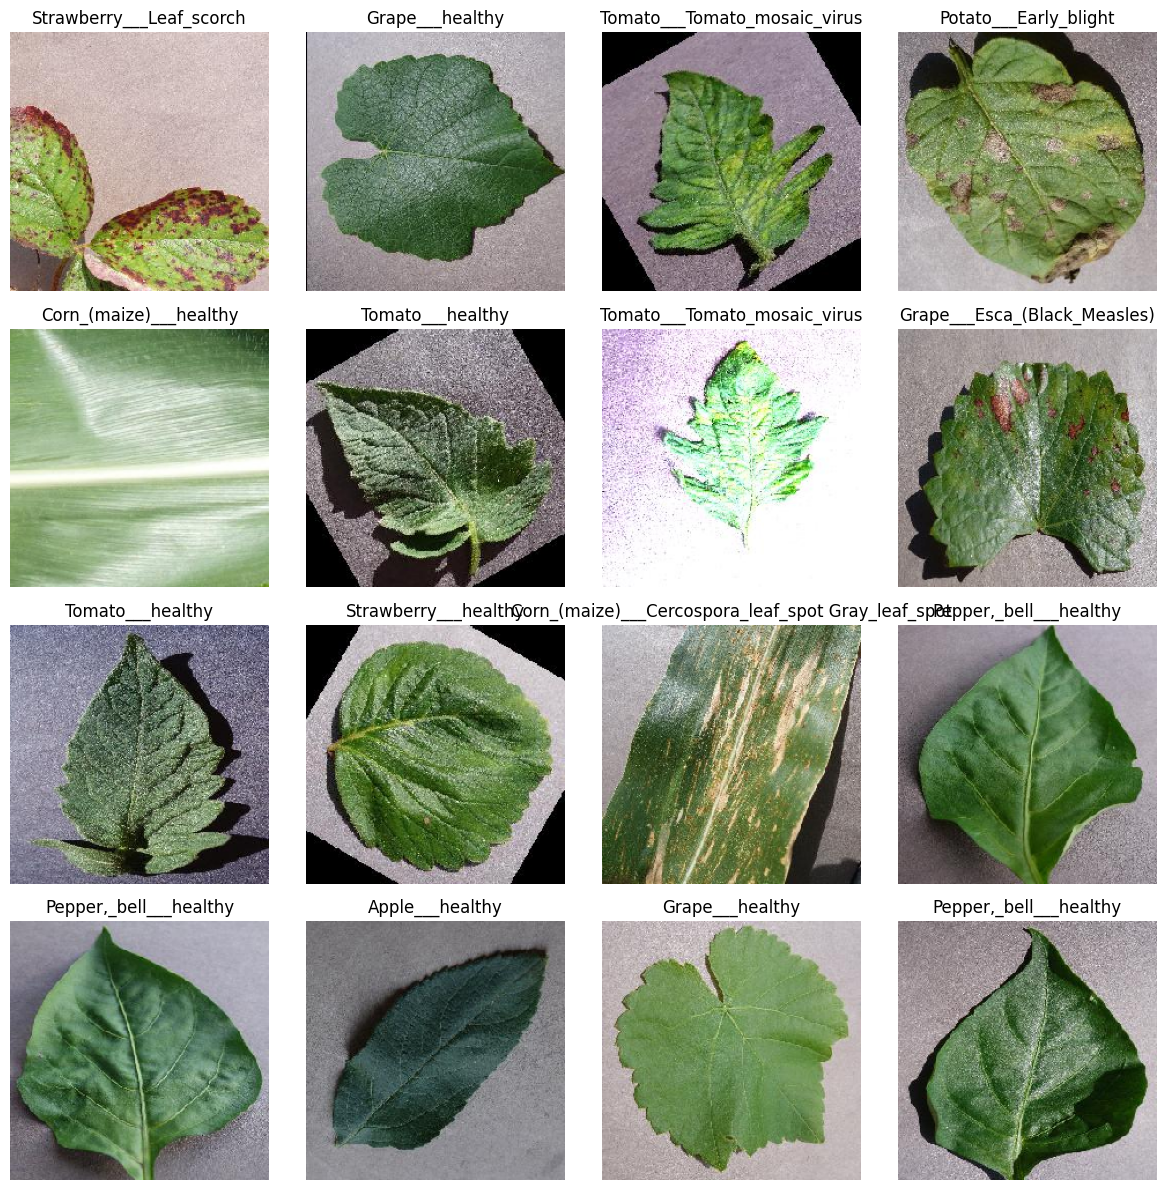

In [ ]:
import random

images, labels = next(iter(train_data))

indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Get Labels from Test Folder

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to test images
test_dir = "path_to_test_folder"
image_size = (224, 224)  # Adjust based on your model
class_names = sorted([
    'AppleCedarRust', 'AppleScab', 'CornCommonRust', 'PotatoEarlyBlight',
    'PotatoHealthy', 'TomatoEarlyBlight', 'TomatoHealthy', 'TomatoYellowCurlVirus'
])  # Must match training class order

# Load trained model
model = load_model("xception_model.h5")

y_true = []
y_pred = []

# Process each test image
for fname in os.listdir(test_dir):
    if fname.endswith('.JPG') or fname.endswith('.jpg'):
        # Get label from filename
        for cls in class_names:
            if fname.startswith(cls):
                label = cls
                break
        else:
            continue  # Skip if class not found

        # Load and preprocess image
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=image_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)
        predicted_label = class_names[np.argmax(prediction)]

        y_true.append(label)
        y_pred.append(predicted_label)

These test files are processed at the END OF MODEL TRAINING.

# **Choose 2 CNN Architectures**

Our choices? Here:

🔹 1. **ResNet (Residual Network)**

A deep learning classic known for its skip connections, which help the model avoid vanishing gradients and train very deep networks effectively.

Great for a wide range of tasks

Learns faster and performs reliably

Medium computational cost

🔹 2.  **Xception**

An advanced architecture based on depthwise separable convolutions, making it both efficient and powerful.

Achieves high accuracy with fewer parameters than many older models like Inception.

Faster than heavyweight models, while still maintaining strong performance.

Well-suited for transfer learning tasks due to its clean, modular design.

# Why did we choose these CNNS?

We chose ResNet50 and Xception because of their proven effectiveness in image classification and popularity in transfer learning.
ResNet50 uses residual connections to enable deep networks to train efficiently and is well-suited for fast experimentation.
Xception leverages depthwise separable convolutions for improved performance and efficiency, often outperforming older architectures like Inception.
Compared to heavier models, Xception strikes a good balance between speed and accuracy, making it a strong candidate for real-world applications.

## **Helper functions for plotting**

For Loss/Acc Curves

In [ ]:
def plot_learning_curves(history, model_name):
    """Plots the training and validation accuracy/loss curves.

    Args:
        history: The training history object.
        model_name: Name of the model for the plot title.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

For Conf Matrix

In [ ]:
def plot_confusion_matrix(model, test_data, model_name):
    """Plots the confusion matrix for a given model and test data.

    Args:
        model: The trained Keras model.
        test_data: The test data generator.
        model_name: Name of the model for the plot title.
    """
    # Get predictions and true labels
    y_true = test_data.classes
    y_pred = model.predict(test_data, steps=len(test_data), verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_labels = list(test_data.class_indices.keys())

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

For Misclassified Samples

In [ ]:
def display_misclassified_images(model, test_data, num_images=5):
    """Displays a few misclassified images from the test set.

    Args:
        model: The trained Keras model.
        test_data: The test data generator.
        num_images: The number of misclassified images to display.
    """
    # Get predictions
    y_true = test_data.classes
    y_pred = model.predict(test_data, steps=len(test_data), verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Find misclassified images
    misclassified_indices = np.where(y_true != y_pred_classes)[0]
    if len(misclassified_indices) == 0:
        print("No misclassified images found.")
        return

    # Randomly select misclassified images to display
    num_images = min(num_images, len(misclassified_indices))  # Ensure not exceeding available misclassified
    selected_indices = np.random.choice(misclassified_indices, num_images, replace=False)

    # Display misclassified images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        image, label = test_data[idx // test_data.batch_size] # get image and label.  Integer division
        image = image[idx % test_data.batch_size] # index into the batch
        true_label = list(test_data.class_indices.keys())[label[0].argmax()]
        predicted_label = list(test_data.class_indices.keys())[y_pred_classes[idx]]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## **Training functions**

For Building The Model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation

In [ ]:
def build_model(base_model, trainable=False):
    """
    Builds a model with a pre-trained base model.

    Args:
        base_model: A pre-trained model (e.g., ResNet50, Xception).
        trainable: Whether to train the base model's weights.

    Returns:
        A Keras model.
    """
    for layer in base_model.layers:
          layer.trainable = trainable

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(len(train_data.class_indices), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def build_finetune_model(base_model): # for finetuned model
    """
    Builds a fine-tuning model by freezing the bottom half of the base model's layers.

    Args:
        base_model: A pre-trained base model (e.g., ResNet50, EfficientNetV2L).

    Returns:
        A compiled Keras model ready for fine-tuning.
    """
    num_layers = len(base_model.layers)
    for i, layer in enumerate(base_model.layers):
      layer.trainable = i >= int(0.75 * num_layers) # unfreeze 25% of upper layers for EfficientNet..0.5 for ResNet50

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(len(train_data.class_indices), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


For Training/Evaluating The Model

In [ ]:
def train_and_evaluate_model(model, model_name, train_data, valid_data, test_data, epochs=10):
    """
    Trains and evaluates a model.

    Args:
        model: The Keras model to train.
        model_name: Name for saving model weights.
        train_data: Training data generator.
        valid_data: Validation data generator.
        test_data: Testing data generator.
        epochs: Number of epochs to train.

    Returns:
        The trained model and its history.
    """
    # Define callbacks
    checkpoint_path = f"{model_name}_best_model.h5"
    checkpoint = ModelCheckpoint(checkpoint_path,
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )


    # Load the best model
    best_model = load_model(checkpoint_path)
    test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    return best_model, history

# **Apply Transfer Learning in Two Ways**

# ResNet-50

Feature Extraction

In [ ]:
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # load resnet50 base model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Extract The Features

In [ ]:
resnet50_feature_extractor = build_model(resnet50_base_model, trainable=False) # build the model
resnet50_feature_extractor.summary() # summary/architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,236,326 (100.08 MB)

 Trainable params: 2,645,542 (10.09 MB)

 Non-trainable params: 23,590,784 (89.99 MB)

**Train The Model**

In [ ]:
resnet50_feature_extractor, resnet50_feature_extractor_history = train_and_evaluate_model(
    resnet50_feature_extractor, "ResNet50_feature_extractor", train_data, valid_data,test_data, epochs=epochs
)

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3734 - loss: 2.2210
Epoch 1: val_accuracy improved from -inf to 0.06715, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 260s 273ms/step - accuracy: 0.3736 - loss: 2.2205 - val_accuracy: 0.0672 - val_loss: 8.1101 - learning_rate: 0.0010
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5958 - loss: 1.3077
Epoch 2: val_accuracy improved from 0.06715 to 0.08775, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 198s 225ms/step - accuracy: 0.5958 - loss: 1.3077 - val_accuracy: 0.0878 - val_loss: 11.1424 - learning_rate: 0.0010
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6470 - loss: 1.1210
Epoch 3: val_accuracy improved from 0.08775 to 0.14808, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 199s 226ms/step - accuracy: 0.6470 - loss: 1.1210 - val_accuracy: 0.1481 - val_loss: 5.5021 - learning_rate: 0.0010
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6733 - loss: 1.0294
Epoch 4: val_accuracy did not improve from 0.14808
879/879 ━━━━━━━━━━━━━━━━━━━━ 194s 221ms/step - accuracy: 0.6733 - loss: 1.0294 - val_accuracy: 0.1372 - val_loss: 6.9975 - learning_rate: 0.0010
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6997 - loss: 0.9552
Epoch 5: val_accuracy improved from 0.14808 to 0.24983, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 198s 225ms/step - accuracy: 0.6997 - loss: 0.9552 - val_accuracy: 0.2498 - val_loss: 3.2700 - learning_rate: 0.0010
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7083 - loss: 0.9099
Epoch 6: val_accuracy did not improve from 0.24983
879/879 ━━━━━━━━━━━━━━━━━━━━ 198s 225ms/step - accuracy: 0.7083 - loss: 0.9098 - val_accuracy: 0.2344 - val_loss: 3.6653 - learning_rate: 0.0010
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7239 - loss: 0.8615
Epoch 7: val_accuracy improved from 0.24983 to 0.29365, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 199s 226ms/step - accuracy: 0.7239 - loss: 0.8614 - val_accuracy: 0.2936 - val_loss: 3.5831 - learning_rate: 0.0010
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7366 - loss: 0.8158
Epoch 8: val_accuracy improved from 0.29365 to 0.31408, saving model to ResNet50_feature_extractor_best_model.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
879/879 ━━━━━━━━━━━━━━━━━━━━ 247s 281ms/step - accuracy: 0.7366 - loss: 0.8158 - val_accuracy: 0.3141 - val_loss: 3.5089 - learning_rate: 0.0010
Epoch 9/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7661 - loss: 0.7191
Epoch 9: val_accuracy improved from 0.31408 to 0.68216, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 219s 232ms/step - accuracy: 0.7662 - loss: 0.7191 - val_accuracy: 0.6822 - val_loss: 0.9940 - learning_rate: 2.0000e-04
Epoch 10/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7917 - loss: 0.6434
Epoch 10: val_accuracy improved from 0.68216 to 0.69844, saving model to ResNet50_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 190s 216ms/step - accuracy: 0.7917 - loss: 0.6434 - val_accuracy: 0.6984 - val_loss: 0.9166 - learning_rate: 2.0000e-04


ResNet50_feature_extractor Test Accuracy: 0.6905, Test Loss: 0.9466


Results:

📦 ResNet50 (Feature Extractor):
Reached Test Accuracy: 69.05% and Loss: 0.9466, showing limited performance.
Only the classifier layers were trained while the base was frozen.
While faster to train, it underperformed due to lack of dataset-specific fine-tuning.

**Visualise/Plot Curves and Confusion Matrix**

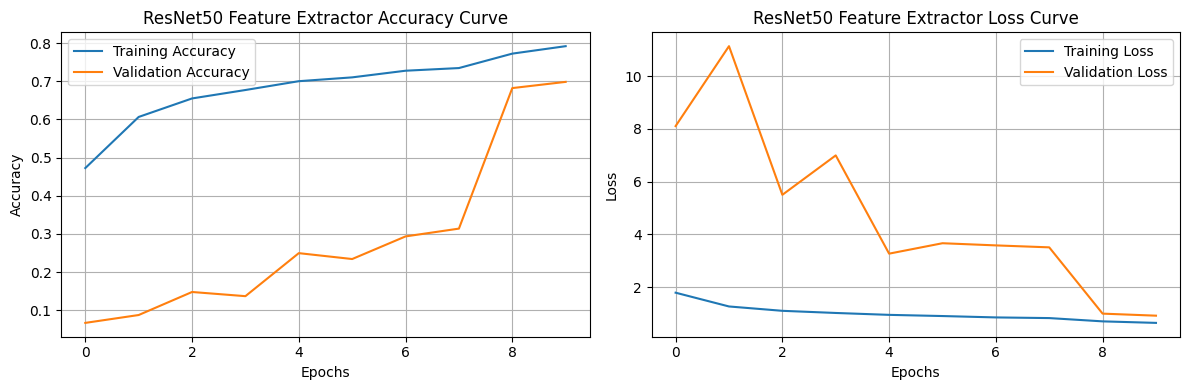

In [ ]:
plot_learning_curves(resnet50_feature_extractor_history, "ResNet50 Feature Extractor")  # loss curves

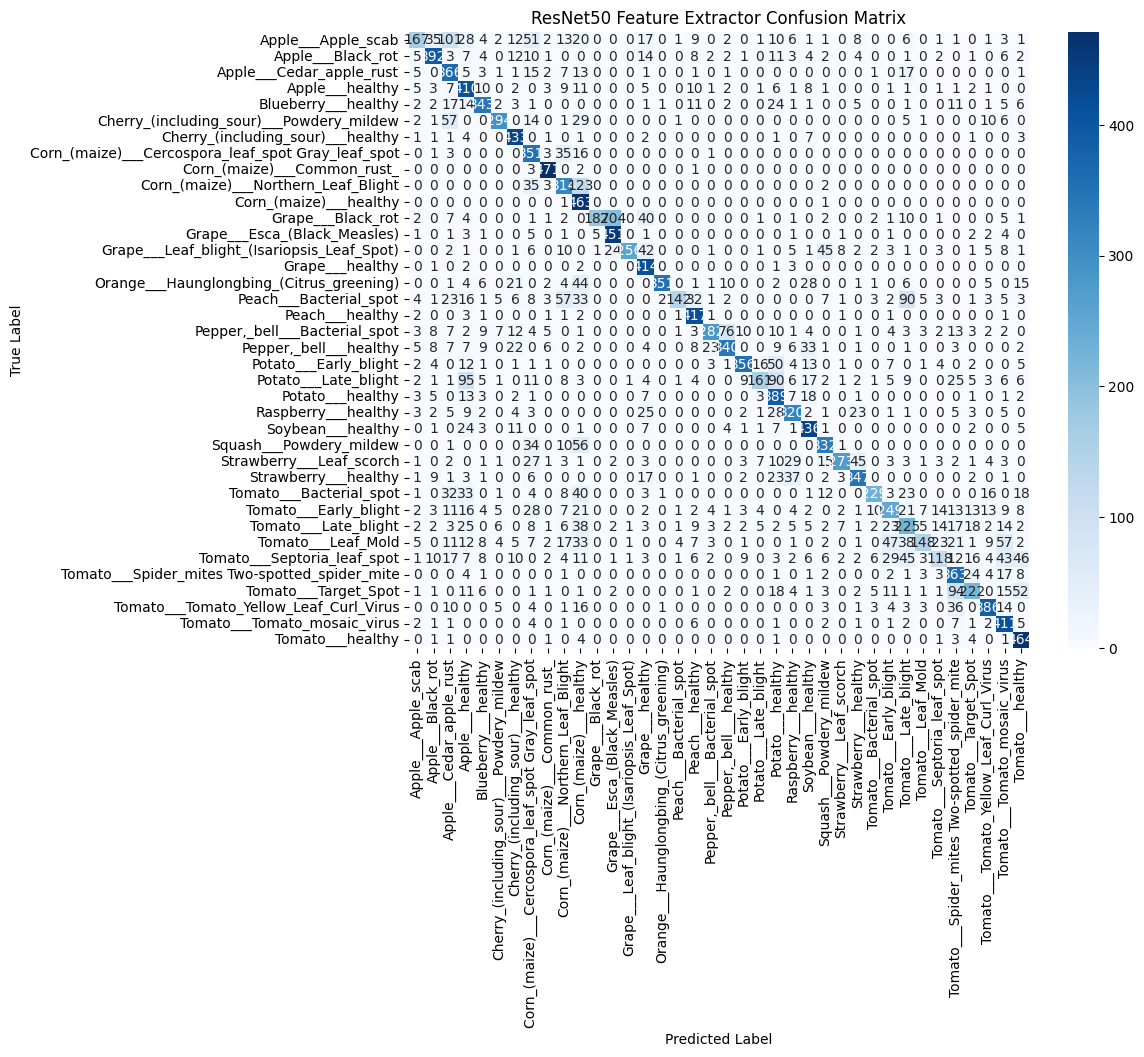

ResNet50 Feature Extractor Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.73      0.33      0.46       504
                                 Apple___Black_rot       0.80      0.79      0.79       497
                          Apple___Cedar_apple_rust       0.52      0.83      0.64       440
                                   Apple___healthy       0.53      0.82      0.64       502
                               Blueberry___healthy       0.79      0.76      0.77       454
          Cherry_(including_sour)___Powdery_mildew       0.88      0.70      0.78       421
                 Cherry_(including_sour)___healthy       0.78      0.95      0.85       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.55      0.86      0.67       410
                       Corn_(maize)___Common_rust_       0.92      0.99      0.95       477
               Corn_(maize)__

In [ ]:
plot_confusion_matrix(resnet50_feature_extractor, valid_data, "ResNet50 Feature Extractor") # conf matrix

**Misclassified Samples**

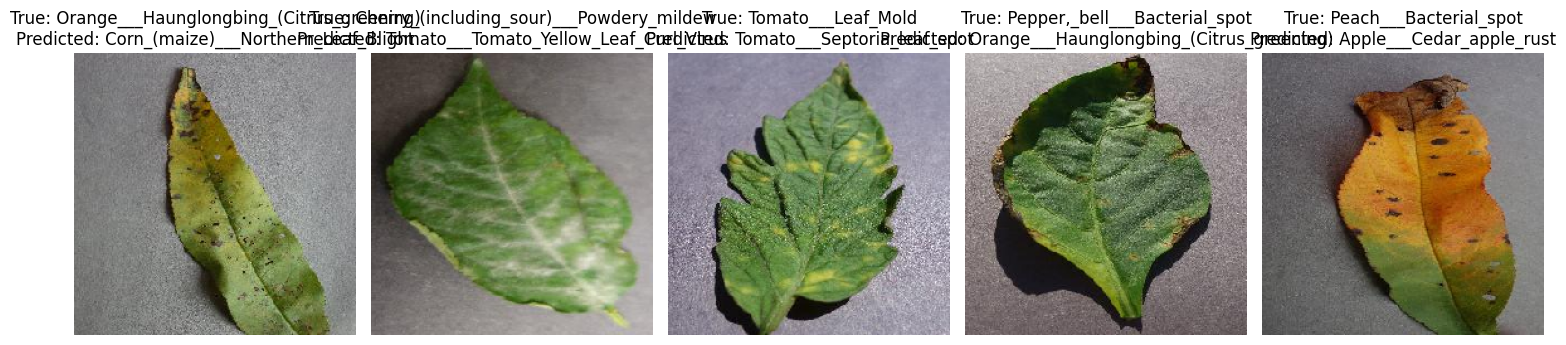

In [ ]:
display_misclassified_images(resnet50_feature_extractor, test_data) # display some misclassified images

# ResNet-50 With Fine-Tuning

**Build Unfrozen Model (Unfreeze Half Of The layers)**

In [ ]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_fine_tuning = build_finetune_model(resnet50_base_model) # Set trainable to True for fine-tuning
resnet50_fine_tuning.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,236,326 (100.08 MB)

 Trainable params: 24,007,718 (91.58 MB)

 Non-trainable params: 2,228,608 (8.50 MB)

**Training The Finetuned Model**

In [ ]:
resnet50_fine_tuning, resnet50_fine_tuning_history = train_and_evaluate_model( # train the finetuned model
    resnet50_fine_tuning, "ResNet50_fine_tuning", train_data, valid_data,test_data,epochs=epochs
)

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.3633 - loss: 2.3758
Epoch 1: val_accuracy improved from -inf to 0.34293, saving model to ResNet50_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 395s 402ms/step - accuracy: 0.3636 - loss: 2.3748 - val_accuracy: 0.3429 - val_loss: 2.7306 - learning_rate: 1.0000e-04
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8169 - loss: 0.6114
Epoch 2: val_accuracy improved from 0.34293 to 0.62537, saving model to ResNet50_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 332s 377ms/step - accuracy: 0.8169 - loss: 0.6113 - val_accuracy: 0.6254 - val_loss: 1.3016 - learning_rate: 1.0000e-04
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8987 - loss: 0.3346
Epoch 3: val_accuracy did not improve from 0.62537
879/879 ━━━━━━━━━━━━━━━━━━━━ 362s 412ms/step - accuracy: 0.8987 - loss: 0.3346 - val_accuracy: 0.4422 - val_loss: 2.4514 - learning_rate: 1.0000e-04
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9283 - loss: 0.2332
Epoch 4: val_accuracy did not improve from 0.62537
879/879 ━━━━━━━━━━━━━━━━━━━━ 363s 413ms/step - accuracy: 0.9283 - loss: 0.2332 - val_accuracy: 0.5893 - val_loss: 1.6759 - learning_rate: 1.0000e-04
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9434 - loss: 0.1827
Epoch 5: val_accuracy did not improve from 0.62537

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
879/879 ━━━━━━━━━━━━━━━━━━━━ 324s 369ms/step - accuracy: 0

879/879 ━━━━━━━━━━━━━━━━━━━━ 334s 379ms/step - accuracy: 0.9724 - loss: 0.0903 - val_accuracy: 0.9742 - val_loss: 0.0803 - learning_rate: 2.0000e-05
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9862 - loss: 0.0493
Epoch 7: val_accuracy did not improve from 0.97422
879/879 ━━━━━━━━━━━━━━━━━━━━ 373s 369ms/step - accuracy: 0.9862 - loss: 0.0493 - val_accuracy: 0.9564 - val_loss: 0.1397 - learning_rate: 2.0000e-05
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9882 - loss: 0.0390
Epoch 8: val_accuracy did not improve from 0.97422
879/879 ━━━━━━━━━━━━━━━━━━━━ 325s 370ms/step - accuracy: 0.9882 - loss: 0.0390 - val_accuracy: 0.9026 - val_loss: 0.3311 - learning_rate: 2.0000e-05
Epoch 9/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9909 - loss: 0.0323
Epoch 9: val_accuracy did not improve from 0.97422

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
879/879 ━━━━━━━━━━━━━━━━━━━━ 324s 369ms/step - accuracy: 0.

879/879 ━━━━━━━━━━━━━━━━━━━━ 333s 379ms/step - accuracy: 0.9944 - loss: 0.0229 - val_accuracy: 0.9849 - val_loss: 0.0479 - learning_rate: 4.0000e-06


ResNet50_fine_tuning Test Accuracy: 0.9776, Test Loss: 0.0734


Results:

🔧 ResNet50 (Fine-Tuning):
Achieved excellent performance with Test Accuracy: **97.76%** and Loss: 0.0734.
Fine-tuning allowed the model to adapt deeper features to the plant disease dataset.
This result reflects strong generalization and effective transfer learning.

**Visualise/Plot Curves and Confusion Matrix**

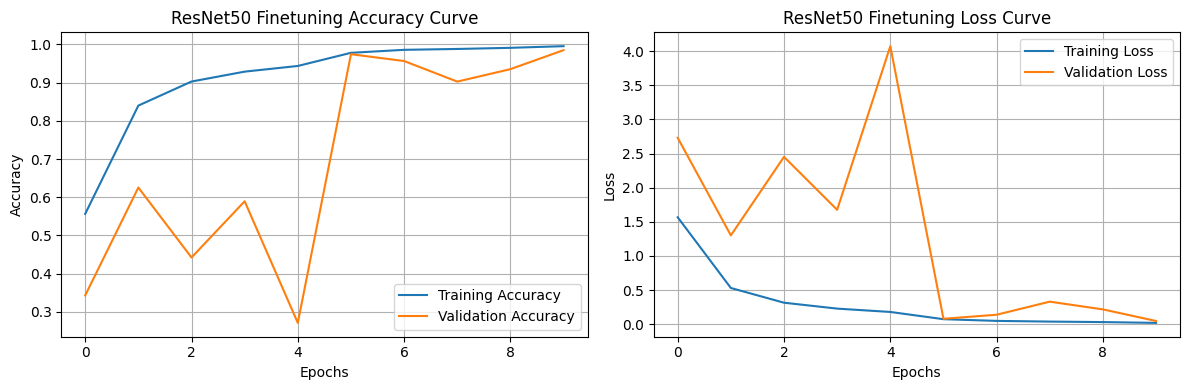

In [ ]:
plot_learning_curves(resnet50_fine_tuning_history, "ResNet50 Finetuning") # curves

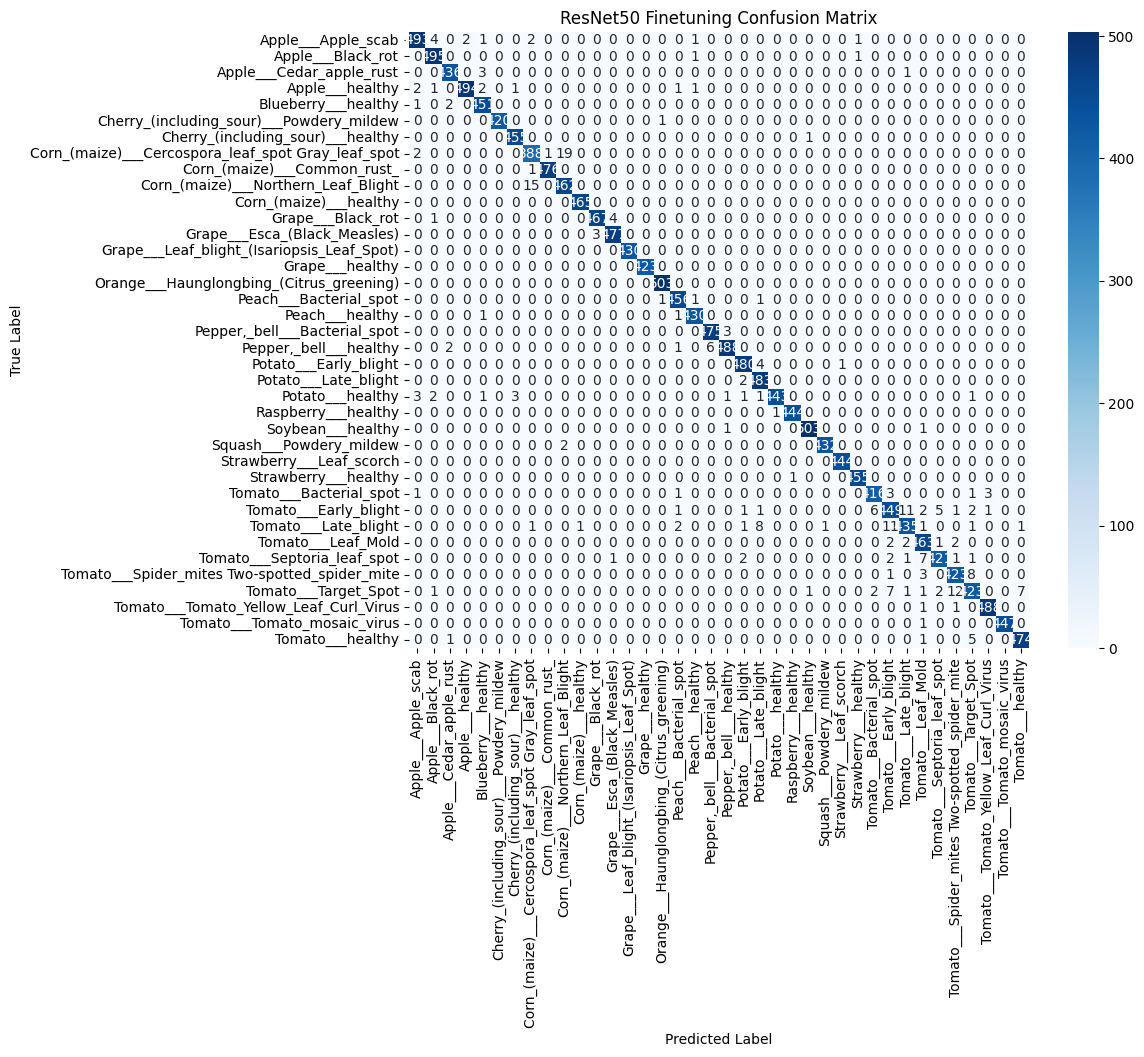

ResNet50 Finetuning Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98       504
                                 Apple___Black_rot       0.98      1.00      0.99       497
                          Apple___Cedar_apple_rust       0.99      0.99      0.99       440
                                   Apple___healthy       1.00      0.98      0.99       502
                               Blueberry___healthy       0.98      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       0.99      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.95      0.95       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northe

In [ ]:
plot_confusion_matrix(resnet50_fine_tuning, valid_data, "ResNet50 Finetuning") # conf matrix

**Misclassified Samples**

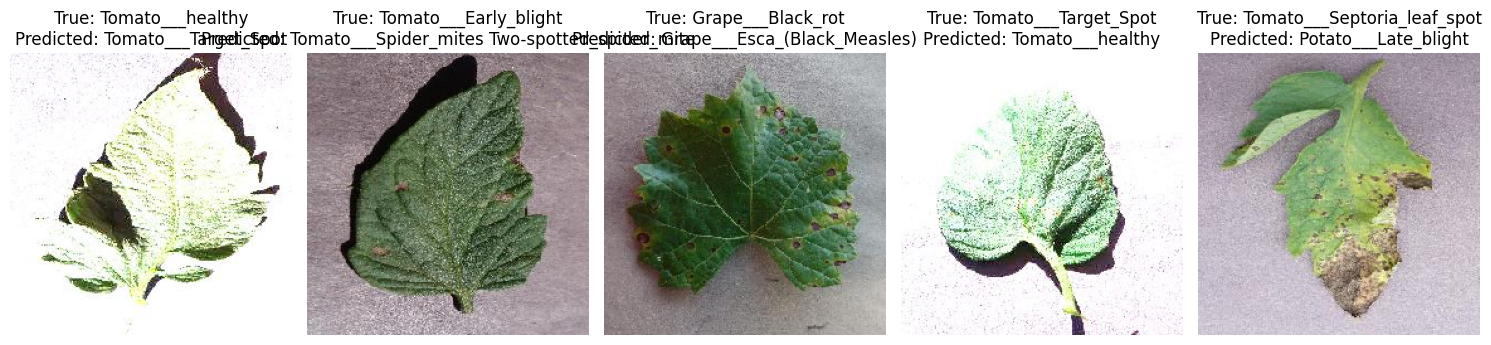

In [ ]:
display_misclassified_images(resnet50_fine_tuning, test_data) # display some misclassified images

# **Xception**

load the base model

In [ ]:
print("\n--- Xception ---")
xception_base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


--- Xception ---
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Feature Extraction

Build The Model

In [ ]:
xception_feature_extractor = build_model(xception_base_model, trainable=False) # build model
xception_feature_extractor.summary() # summary/architecture

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,510,094 (89.68 MB)

 Trainable params: 2,645,542 (10.09 MB)

 Non-trainable params: 20,864,552 (79.59 MB)

**Train The Model**

In [ ]:
xception_feature_extractor, xception_feature_extractor_history = train_and_evaluate_model(
    xception_feature_extractor, "xception_feature_extractor", train_data, valid_data, test_data, epochs=epochs
)

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7183 - loss: 0.9721
Epoch 1: val_accuracy improved from -inf to 0.89916, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 339s 361ms/step - accuracy: 0.7184 - loss: 0.9717 - val_accuracy: 0.8992 - val_loss: 0.3083 - learning_rate: 0.0010
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8802 - loss: 0.3556
Epoch 2: val_accuracy improved from 0.89916 to 0.91612, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 275s 313ms/step - accuracy: 0.8802 - loss: 0.3556 - val_accuracy: 0.9161 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9052 - loss: 0.2804
Epoch 3: val_accuracy improved from 0.91612 to 0.92682, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 278s 316ms/step - accuracy: 0.9052 - loss: 0.2804 - val_accuracy: 0.9268 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9197 - loss: 0.2385
Epoch 4: val_accuracy improved from 0.92682 to 0.93325, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 277s 315ms/step - accuracy: 0.9197 - loss: 0.2385 - val_accuracy: 0.9332 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9276 - loss: 0.2173
Epoch 5: val_accuracy improved from 0.93325 to 0.93860, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 277s 315ms/step - accuracy: 0.9276 - loss: 0.2173 - val_accuracy: 0.9386 - val_loss: 0.1840 - learning_rate: 0.0010
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9330 - loss: 0.2011
Epoch 6: val_accuracy improved from 0.93860 to 0.94309, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 275s 312ms/step - accuracy: 0.9330 - loss: 0.2011 - val_accuracy: 0.9431 - val_loss: 0.1693 - learning_rate: 0.0010
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9419 - loss: 0.1747
Epoch 7: val_accuracy improved from 0.94309 to 0.94799, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 276s 314ms/step - accuracy: 0.9419 - loss: 0.1748 - val_accuracy: 0.9480 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9428 - loss: 0.1637
Epoch 8: val_accuracy did not improve from 0.94799
879/879 ━━━━━━━━━━━━━━━━━━━━ 275s 313ms/step - accuracy: 0.9428 - loss: 0.1637 - val_accuracy: 0.9448 - val_loss: 0.1672 - learning_rate: 0.0010
Epoch 9/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9454 - loss: 0.1588
Epoch 9: val_accuracy did not improve from 0.94799
879/879 ━━━━━━━━━━━━━━━━━━━━ 275s 313ms/step - accuracy: 0.9454 - loss: 0.1588 - val_accuracy: 0.9468 - val_loss: 0.1608 - learning_rate: 0.0010
Epoch 10/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9448 - loss: 0.1571
Epoch 10: val_accuracy improved from 0.94799 to 0.95026, saving model to xception_feature_extractor_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 276s 313ms/step - accuracy: 0.9448 - loss: 0.1571 - val_accuracy: 0.9503 - val_loss: 0.1548 - learning_rate: 0.0010


xception_feature_extractor Test Accuracy: 0.9352, Test Loss: 0.1947


Plot Curves/CM

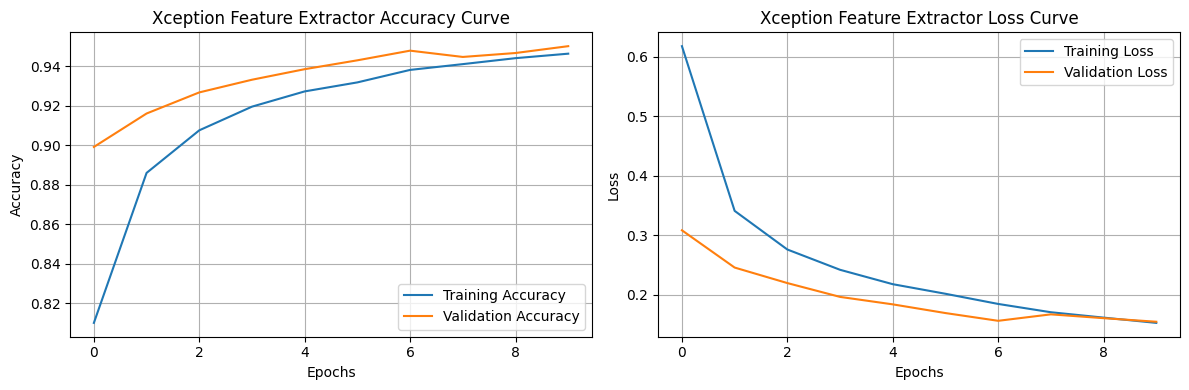

In [ ]:
plot_learning_curves(xception_feature_extractor_history, "Xception Feature Extractor")

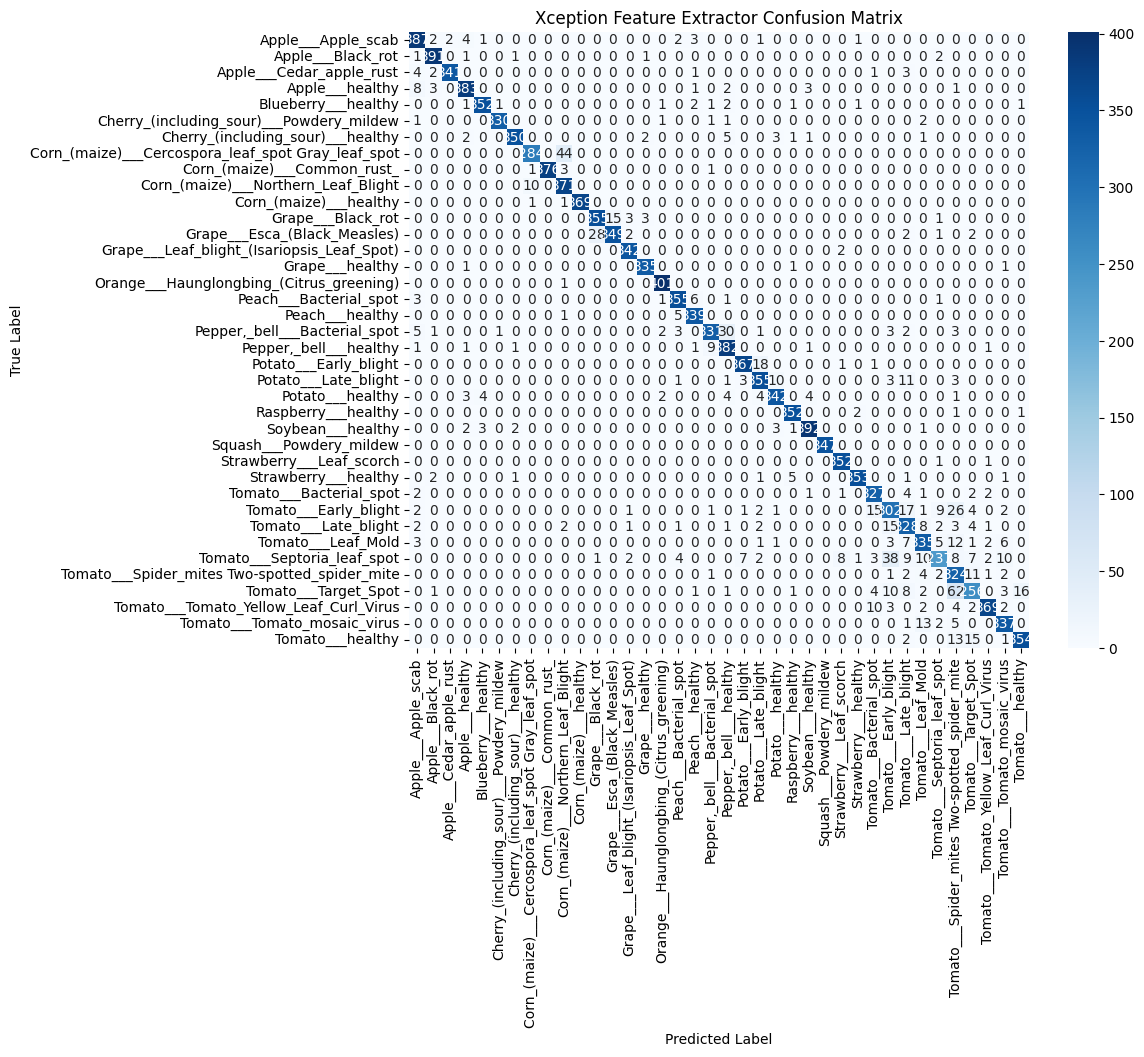

Xception Feature Extractor Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.96      0.94       403
                                 Apple___Black_rot       0.97      0.98      0.98       397
                          Apple___Cedar_apple_rust       0.99      0.97      0.98       352
                                   Apple___healthy       0.96      0.96      0.96       401
                               Blueberry___healthy       0.98      0.97      0.97       363
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.99       336
                 Cherry_(including_sour)___healthy       0.99      0.96      0.97       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.87      0.91       328
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       381
               Corn_(maize)__

In [ ]:
plot_confusion_matrix(xception_feature_extractor, test_data, "Xception Feature Extractor")

Misclassified Samples

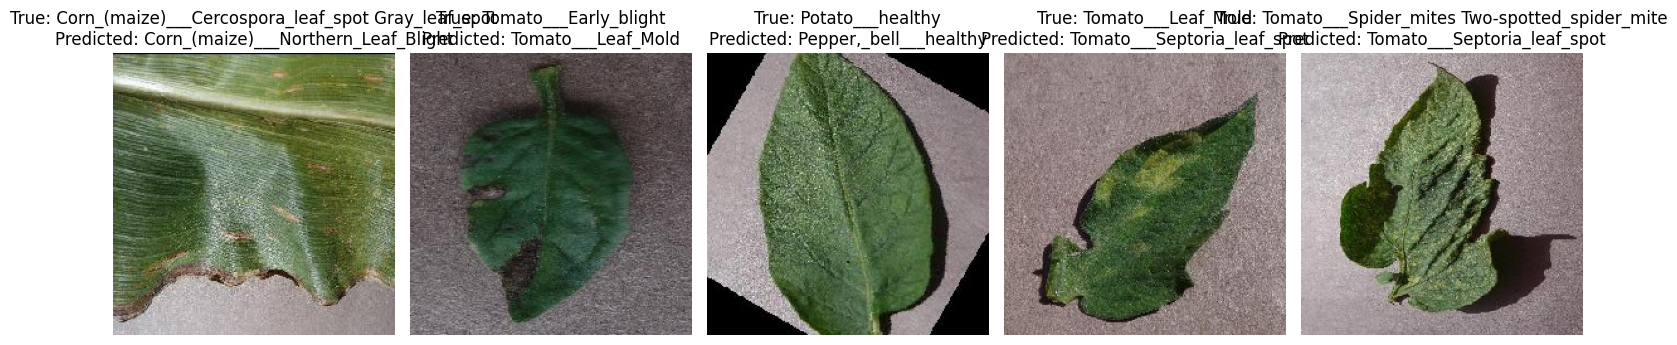

In [ ]:
display_misclassified_images(xception_feature_extractor, test_data)

Results:

Result Analysis (Xception – Feature Extractor):

The Xception-based feature extractor achieved a training accuracy of 94.48% with a loss of 0.1571, indicating effective learning from the training set.

Validation accuracy reached 95.03%, slightly outperforming training accuracy and showing good generalization with minimal overfitting.

The test accuracy was 93.52%, with a test loss of 0.1947, suggesting consistent performance across unseen data.

The base Xception model was frozen, so only the classifier layers were trained; this limited deeper feature adaptation to the specific plant disease dataset.

While results are strong, performance could likely improve further through fine-tuning by unfreezing and training upper layers of the Xception backbone.

# Fine Tuning Xception

**Build Unfrozen Model (Unfreeze 25% Of The layers)**

In [ ]:
xception_base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_fine_tuning = build_finetune_model(xception_base_model) # build the model
xception_fine_tuning.summary() # summary/architecture

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,510,094 (89.68 MB)

 Trainable params: 12,123,886 (46.25 MB)

 Non-trainable params: 11,386,208 (43.43 MB)

**Train The Model**

In [ ]:
xception_fine_tuning, xception_fine_tuning_history = train_and_evaluate_model( # Train The model
    xception_fine_tuning, "xception_fine_tuning", train_data, valid_data, test_data, epochs=epochs
)

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6686 - loss: 1.3321
Epoch 1: val_accuracy improved from -inf to 0.96682, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 422s 451ms/step - accuracy: 0.6688 - loss: 1.3312 - val_accuracy: 0.9668 - val_loss: 0.1123 - learning_rate: 1.0000e-04
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9744 - loss: 0.1023
Epoch 2: val_accuracy improved from 0.96682 to 0.98042, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 384s 436ms/step - accuracy: 0.9744 - loss: 0.1022 - val_accuracy: 0.9804 - val_loss: 0.0612 - learning_rate: 1.0000e-04
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9884 - loss: 0.0444
Epoch 3: val_accuracy improved from 0.98042 to 0.98185, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 381s 433ms/step - accuracy: 0.9884 - loss: 0.0444 - val_accuracy: 0.9818 - val_loss: 0.0593 - learning_rate: 1.0000e-04
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9921 - loss: 0.0273
Epoch 4: val_accuracy improved from 0.98185 to 0.98532, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 384s 436ms/step - accuracy: 0.9921 - loss: 0.0273 - val_accuracy: 0.9853 - val_loss: 0.0489 - learning_rate: 1.0000e-04
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9950 - loss: 0.0188
Epoch 5: val_accuracy improved from 0.98532 to 0.98725, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 384s 436ms/step - accuracy: 0.9950 - loss: 0.0188 - val_accuracy: 0.9873 - val_loss: 0.0428 - learning_rate: 1.0000e-04
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9964 - loss: 0.0136
Epoch 6: val_accuracy did not improve from 0.98725
879/879 ━━━━━━━━━━━━━━━━━━━━ 377s 428ms/step - accuracy: 0.9964 - loss: 0.0136 - val_accuracy: 0.9867 - val_loss: 0.0435 - learning_rate: 1.0000e-04
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9961 - loss: 0.0128
Epoch 7: val_accuracy improved from 0.98725 to 0.98771, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 384s 437ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.9877 - val_loss: 0.0474 - learning_rate: 1.0000e-04
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9966 - loss: 0.0112
Epoch 8: val_accuracy improved from 0.98771 to 0.98919, saving model to xception_fine_tuning_best_model.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 401s 456ms/step - accuracy: 0.9966 - loss: 0.0113 - val_accuracy: 0.9892 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 9/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9971 - loss: 0.0098
Epoch 9: val_accuracy did not improve from 0.98919
879/879 ━━━━━━━━━━━━━━━━━━━━ 379s 431ms/step - accuracy: 0.9971 - loss: 0.0098 - val_accuracy: 0.9891 - val_loss: 0.0379 - learning_rate: 1.0000e-04
Epoch 10/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9976 - loss: 0.0086
Epoch 10: val_accuracy did not improve from 0.98919
879/879 ━━━━━━━━━━━━━━━━━━━━ 377s 429ms/step - accuracy: 0.9976 - loss: 0.0086 - val_accuracy: 0.9841 - val_loss: 0.0656 - learning_rate: 1.0000e-04


xception_fine_tuning Test Accuracy: 0.9848, Test Loss: 0.0581


Plot Curves/CM

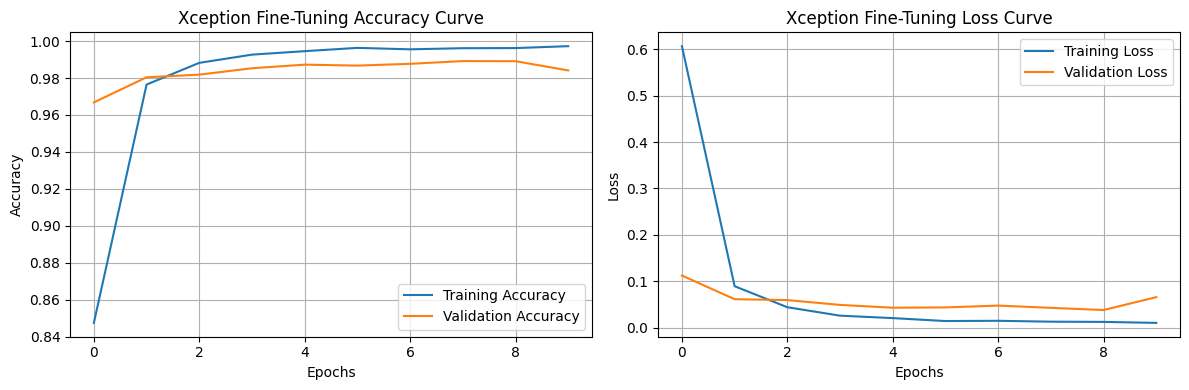

In [ ]:
plot_learning_curves(xception_fine_tuning_history, "Xception Fine-Tuning")

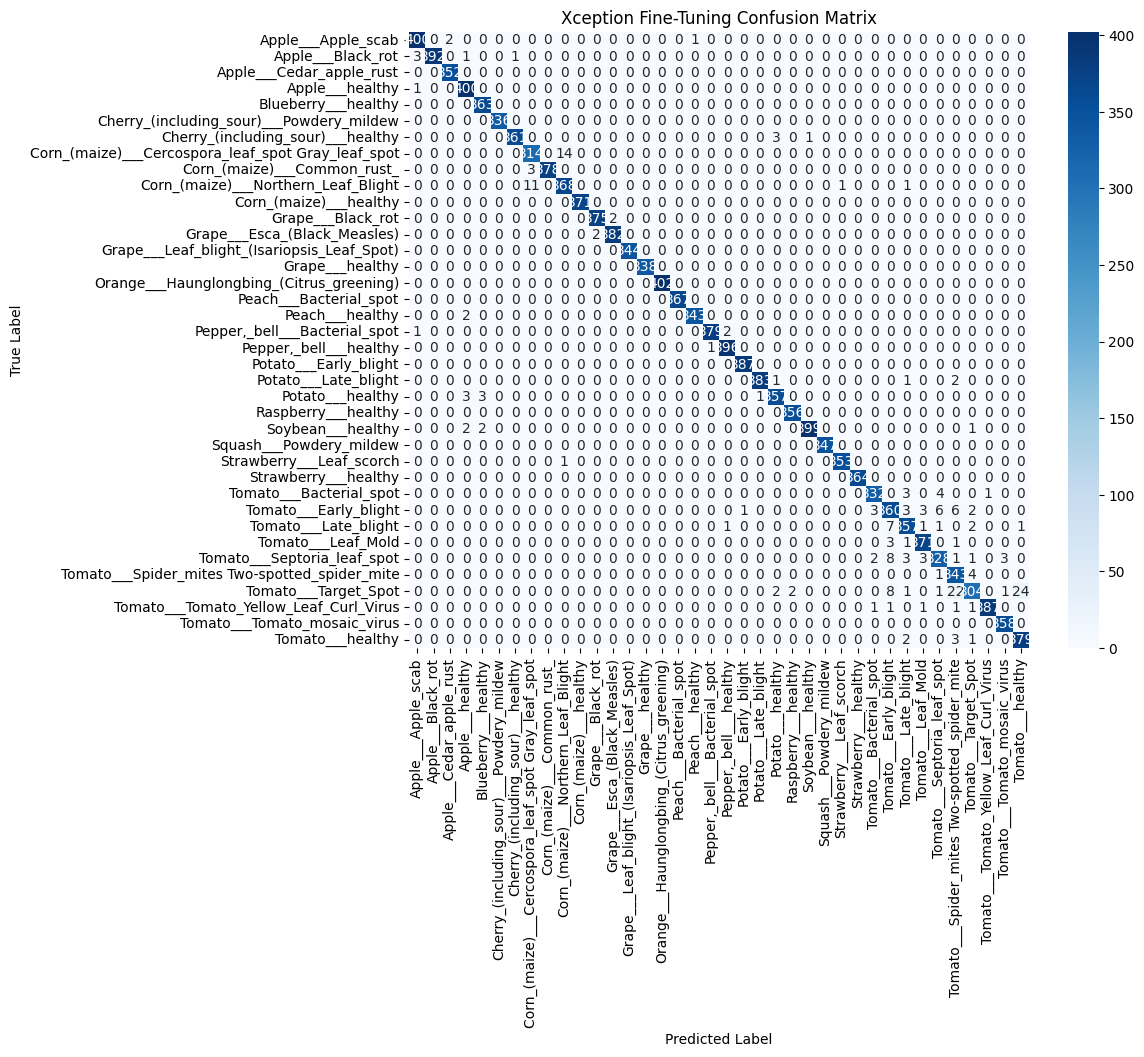

Xception Fine-Tuning Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       403
                                 Apple___Black_rot       1.00      0.99      0.99       397
                          Apple___Cedar_apple_rust       0.99      1.00      1.00       352
                                   Apple___healthy       0.98      1.00      0.99       401
                               Blueberry___healthy       0.99      1.00      0.99       363
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       336
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.96      0.96       328
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       381
               Corn_(maize)___North

In [ ]:
plot_confusion_matrix(xception_fine_tuning, test_data, "Xception Fine-Tuning")

Misclassified Samples

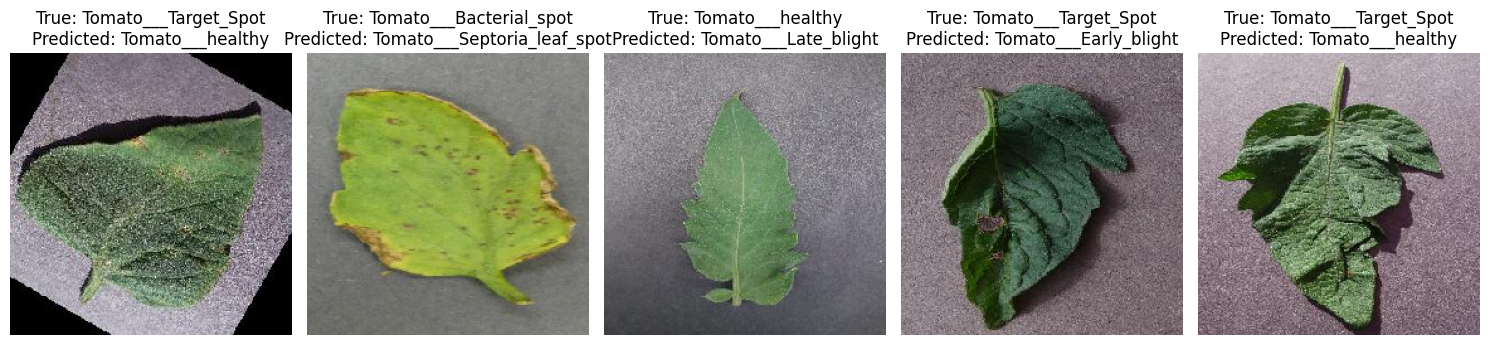

In [ ]:
display_misclassified_images(xception_fine_tuning, test_data)

Results:

Result Analysis (Xception – Fine-Tuned with 25% Upper Layers Unfrozen):

The fine-tuned Xception model achieved a training accuracy of 99.76% with an impressively low loss of 0.0086, indicating near-perfect learning on the training data.

Validation accuracy stood at 98.41% with a val loss of 0.0656, showcasing excellent generalization and minimal overfitting.

On the test set, the model reached a test accuracy of 98.48% and loss of 0.0581, confirming robust performance on unseen data.

Unfreezing the top 25% of the Xception layers enabled the model to fine-tune deeper features, significantly enhancing performance compared to feature extraction.

The results validate the effectiveness of transfer learning with partial fine-tuning, making the model highly suited for the plant disease classification task.

# **Comparitive Analyses**

Xception (with fine-tuning) outperformed ResNet50 with a higher test accuracy (98.48%) and lower test loss (0.0581), indicating better generalization on the plant disease dataset.
ResNet50 fine-tuned also performed well (97.76% accuracy), but slightly under Xception, likely due to Xception's deeper and more efficient architecture for image feature extraction.
However, ResNet50 trained faster and more stably during feature extraction, while Xception needed fine-tuning to reach peak performance—making ResNet better for quick baseline training.

# **How can we improve?**

Use Larger or Ensemble Models: Combine predictions from multiple fine-tuned models (e.g., ResNet + Xception + EfficientNet) to reduce variance and boost accuracy.

Advanced Augmentation: Apply more diverse data augmentation (CutMix, MixUp, Random Erasing) to improve generalization and robustness.

Learning Rate Schedulers + Optimizer Tweaks: Experiment with optimizers like AdamW or Rectified Adam and dynamic learning rate schedulers like Cosine Annealing or One Cycle Policy.

More Fine-Tuning: Unfreeze more layers or use discriminative learning rates—lower for early layers, higher for later ones—for better adaptation.

Use Pretrained Models on Similar Domains: Try models pretrained on plant-specific datasets (like PlantCLEF) rather than generic ImageNet.

-------------------- end